In [1]:
import sys
sys.path.append('./../')
import src
from src import proyecto_1
from src.utils import utils
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from numpy import savetxt
from matplotlib import pyplot

In [2]:
proyecto_1.main()

./..\src\pipelines\feature_engineering.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)


In [3]:
c5_inputs = utils.load_df('output/fe_df.pkl')

### Definimos los nombres de las variables que vamos a usar

In [4]:
names=np.array(c5_inputs.dia_semana.unique())
names=np.append(names,np.array(c5_inputs.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_inputs.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_inputs.tipo_entrada.unique()))
names=np.append(names,np.array(c5_inputs.mes.unique()))
names=np.append(names,np.array(['sin_time', 'cos_time']))

### Definimos los transformadores de las variables categoricas y la imputacion de datos con la media de coseno y seno del tiempo

In [5]:
transformers = [('one_hot', OneHotEncoder(), ['dia_semana', 'delegacion_inicio','clas_con_f_alarma','tipo_entrada','mes']),
               ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
               ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]

In [6]:
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)

In [7]:
col_trans.fit(c5_inputs)

ColumnTransformer(n_jobs=-1,
                  transformers=[('one_hot', OneHotEncoder(),
                                 ['dia_semana', 'delegacion_inicio',
                                  'clas_con_f_alarma', 'tipo_entrada', 'mes']),
                                ('impute_sin_time',
                                 SimpleImputer(strategy='median'),
                                 ['sin_time']),
                                ('impute_cos_time',
                                 SimpleImputer(strategy='median'),
                                 ['cos_time'])],
                  verbose=True)

In [8]:
c5_input_vars = col_trans.transform(c5_inputs)

### Definimos "Variance_Threshold" que nos va a ayudar a eliminar las columnas con varianza menor al 0.1

In [9]:
variance_threshold = VarianceThreshold(threshold=0.1)
c5_input_variance=variance_threshold.fit_transform(c5_input_vars)

### Vemos los nombres de las columnas que tienen varianza mayor a 0.1 y las vamos a ocupar en el modelo de "Random Forest"

In [10]:
dataset = pd.DataFrame({'variance': variance_threshold.variances_, 'col_name': names})
names_2=dataset[dataset['variance']>=0.1].reset_index().col_name
dataset[dataset['variance']>=0.1].reset_index()

,index,variance,col_name
0,0,0.110650,Sábado
1,1,0.122772,Domingo
2,2,0.114309,Lunes
3,3,0.118358,Martes
4,4,0.120546,Miércoles
5,5,0.130882,Jueves
6,6,0.138515,Viernes
7,15,0.135576,COYOACAN
8,24,0.243947,URGENCIAS MEDICAS
9,26,0.242604,DELITO


### Definimos la matriz de las variables para la prediccion y la etiqueta que queremos predecir

In [11]:
X = c5_input_variance
y = c5_inputs.label.values.reshape(c5_input_variance.shape[0],)

### Aplicamos Grid Search para comparar distintos modelos

In [12]:
import time 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [50,100], 
                    'max_depth': [1, 5],
                    'min_samples_split': [2, 5]}

# ocupemos grid search!
gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision',
                           cv = 5, 
                           n_jobs = -1)
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  490.7621021270752


In [13]:
gs.cv_results_

{'mean_fit_time': array([ 41.76589785,  81.01678143,  41.42737122,  78.84584441,
        113.50534668, 223.57919288, 114.84051247, 148.95047488]),
 'std_fit_time': array([ 0.69945732,  1.53870976,  0.85537238,  1.41452053,  2.91752746,
         3.0497589 ,  1.69414642, 30.5710511 ]),
 'mean_score_time': array([1.76828985, 3.18985906, 1.69580545, 3.24692774, 2.04335799,
        3.09742913, 1.94138684, 1.77642002]),
 'std_score_time': array([0.1142616 , 0.08896121, 0.03472335, 0.23770388, 0.10089372,
        0.48530447, 0.03736785, 0.26407575]),
 'param_max_depth': masked_array(data=[1, 1, 1, 1, 5, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 2, 5, 5, 2, 2, 5, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 1

In [14]:
gs.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

In [15]:
gs.best_score_

0.9388312223356177

In [16]:
gs.best_estimator_

RandomForestClassifier(max_depth=5, oob_score=True, random_state=1234)

In [17]:
gs.best_estimator_.oob_score_

0.8017681516671779

### De los mejores estimadores creamos el modelo para la nuectros valores de prueba

In [18]:
rfc=RandomForestClassifier(random_state=1234, min_samples_split=2, n_estimators= 100, max_depth=5)
rfc.fit(X_train, y_train)
pred=rfc.predict(X_test)

### Vemos su Accuracy 

In [19]:
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8026357284418534


In [20]:
importance = gs.best_estimator_.feature_importances_

### Buscamos las variables que aportan mas al modelo

In [21]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00143
Feature: 1, Score: 0.00015
Feature: 2, Score: 0.00014
Feature: 3, Score: 0.00023
Feature: 4, Score: 0.00017
Feature: 5, Score: 0.00095
Feature: 6, Score: 0.00266
Feature: 7, Score: 0.00789
Feature: 8, Score: 0.30126
Feature: 9, Score: 0.44391
Feature: 10, Score: 0.07317
Feature: 11, Score: 0.12085
Feature: 12, Score: 0.03002
Feature: 13, Score: 0.01717


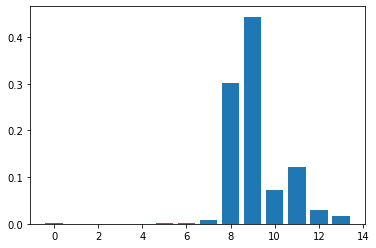

In [22]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Vemos los nombres de las variables que aportan mas al modelo.

In [23]:
dataset_2 = pd.DataFrame({'importance': importance, 'col_name': names_2})
dataset_2[dataset_2['importance']>=0.07].reset_index()

,index,importance,col_name
0,8,0.301261,URGENCIAS MEDICAS
1,9,0.443913,DELITO
2,10,0.073173,REDES
3,11,0.120845,LLAMADA DEL 911
